In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os
import time

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

print(device.type)

# ---

torch.manual_seed(42)
np.random.seed(42)

cuda


In [3]:
def cx_sigm(n=10, t_max=200):
    # rand_btw_7-30 * {-1, 1}
    c1 = (torch.rand(n, 1) * 23 + 7) #* torch.from_numpy(np.random.choice([-1, 1], (n, 1)))  # c1 for steepness
    t = torch.linspace(0, 1, t_max)
    c2 = 0.5  # c2 midpoint
    
    data = 1/(1 + torch.exp(-c1 * (t-c2)))
    return data


def generate_sin(x, amp=1, omega=1, eps=0.1):
    r1 = torch.rand(1)*(eps*2)+(1-eps)
    r2 = torch.rand(1)*(eps*2)+(1-eps)
    r3 = torch.rand(1)*(eps*2)+(1-eps)
    return r1*amp*torch.sin(x*omega+r2)+r3


def generate_cos(x, amp=1, omega=1, eps=0.1):
    r1 = torch.rand(1)*(eps*2)+(1-eps)
    r2 = torch.rand(1)*(eps*2)+(1-eps)
    r3 = torch.rand(1)*(eps*2)+(1-eps)
    return r1*amp*torch.cos(x*omega+r2)+r3


def generate_chainsaw(x, amp=1, mod=0.5, eps=0.1):
    r1 = torch.rand(1)*(eps*2)+(1-eps)
    r2 = torch.rand(1)*(eps*2)+(1-eps)
    r3 = torch.rand(1)*(eps*2)+(1-eps)
    return r1*amp*((x+r2) % (mod))+r3-amp/4


def generate_reverse_chainsaw(x, amp=1, mod=0.5, eps=0.1):
    r1 = torch.rand(1)*(eps*2)+(1-eps)
    r2 = torch.rand(1)*(eps*2)+(1-eps)
    r3 = torch.rand(1)*(eps*2)+(1-eps)
    return -r1*amp*((x+r2) % (mod))+r3+amp/4


t_steps = 200
num_demos = 100
num_val = 20
dx, dy = 1, 1
x = torch.linspace(0, 1, t_steps).repeat(int(num_demos/2), 1)

noise = torch.clamp(torch.randn(x.shape)*1e-4**0.5, min=0) - 0.4
y0 = torch.unsqueeze(generate_chainsaw(x) + noise, 2)

noise = torch.clamp(torch.randn(x.shape)*1e-4**0.5, min=0) - 0.4
y1 = torch.unsqueeze(generate_reverse_chainsaw(x) + noise, 2)

x = torch.unsqueeze(x.repeat(2,1), 2)
y = torch.cat((y0, y1), 0)
print("X:", x.shape, "Y:", y.shape)

path = "."

#######################################

vx = torch.linspace(0, 1, t_steps).repeat(int(num_val/2), 1)
vnoise = torch.clamp(torch.randn(vx.shape)*1e-4**0.5, min=0) - 0.4
# vy0 = torch.unsqueeze(torch.sin(vx*torch.pi) + vnoise, 2)
vy0 = torch.unsqueeze(generate_chainsaw(vx) + vnoise, 2)

vnoise = torch.clamp(torch.randn(vx.shape)*1e-4**0.5, min=0) - 0.4
# vy1 = cx_sigm(int(num_val/2), t_steps).view(int(num_val/2), t_steps, 1)
# vy1 += torch.unsqueeze(vnoise, 2)
vy1 = torch.unsqueeze(generate_reverse_chainsaw(vx) + vnoise, 2)

vx = torch.unsqueeze(vx.repeat(2,1), 2)
vy = torch.cat((vy0, vy1), 0)
print("vX:", vx.shape, "vY:", vy.shape)

X: torch.Size([100, 200, 1]) Y: torch.Size([100, 200, 1])
vX: torch.Size([20, 200, 1]) vY: torch.Size([20, 200, 1])


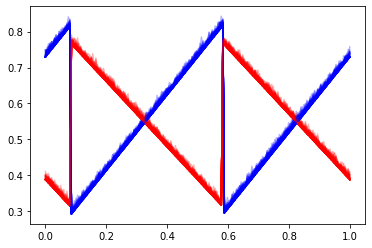

In [4]:
for i in range(int(num_demos/2)):
    plt.plot(x[i, :, 0], y[i, :, 0], 'b', alpha=0.3)
    plt.plot(x[i+int(num_demos/2), :, 0], y[i+int(num_demos/2), :, 0], 'r', alpha=0.3)
plt.show()

In [5]:
n_max = 16

def sample_training_demonstration():    
    rand_traj_ind = np.random.randint(0, num_demos)
    n = np.random.randint(1, n_max+1)

    rand_traj = y[rand_traj_ind, :, :]

    observation_indices = np.random.choice(np.arange(t_steps), n+1, replace=False) # n+1: +1 is for sampling the target
    
    observations = torch.cat((rand_traj[observation_indices[:-1], :], 
                              x[rand_traj_ind, observation_indices[:-1], :]), 1)
    targetX = torch.unsqueeze(torch.Tensor(x[rand_traj_ind, observation_indices[-1], :]), 0)
    targetY = torch.unsqueeze(torch.Tensor(rand_traj[observation_indices[-1], :]), 0)
    
    if device.type == 'cuda':
        return observations.float().cuda(), targetX.float().cuda(), targetY.float().cuda()
    else:
        return observations.float(), targetX.float(), targetY.float()


def get_validation_demonstration(ind):
    x = vx[ind, :, :]
    y = vy[ind, :, :]
    
    if device.type == 'cuda':
        return x.float().cuda(), y.float().cuda()
    else:
        return x, y

In [6]:
class BCNP(nn.Module):
    def __init__(self, in_shape, num_decoders):
        super(BCNP, self).__init__()
        
        self.num_decoders = num_decoders
        dx, dy = in_shape[0], in_shape[1]
        
        dz = 128
        dzt = dz+dx
        
        self.encoder = nn.Sequential(
            nn.Linear(dx+dy, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, dz)
        )
        
        self.gate = nn.Sequential(
            nn.Linear(dz, self.num_decoders),
            nn.Softmax(dim=-1)
        )
        
        decoders = []
        for i in range(self.num_decoders):
            decoders.append(nn.Sequential(
                nn.Linear(dzt, 128),
                nn.ReLU(),
                nn.Linear(128, 256),
                nn.ReLU(),
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.Linear(128, dy*2)
                )
            )
            
        self.decoders = nn.ModuleList(decoders)

#         self.f1 = nn.Sequential(
#             nn.Linear(dzt, 128),
#             nn.ReLU(),
#             nn.Linear(128, 256),
#             nn.ReLU(),
#             nn.Linear(256, 128),
#             nn.ReLU(),
#             nn.Linear(128, dy*2)
#         )
        

    def forward(self, observations, target):
        z_out = self.encoder(observations)
        z = torch.mean(z_out, dim=0)

        zs = z.repeat(target.shape[0], 1).to(device)  # repeating the same z for each target
        z_target = torch.cat((zs, target), 1)
        
        dec_out = torch.zeros(self.num_decoders, dy*2).float().to(device)
        for i in range(self.num_decoders):
            dec_out[i] = self.decoders[i](z_target)
            
        gate_out = self.gate(z)
        
        return dec_out, gate_out


def log_prob_loss(ty, ty_pred):
    m, s = ty_pred.chunk(2, dim = -1)
    s = F.softplus(s)
    dist = D.Independent(D.Normal(loc=m, scale=s), 1)
    return -torch.mean(dist.log_prob(ty))


def plot_trajs(path, i, x, y, pt, col):    
    plt.plot(x, y, 'k', alpha=0.5)
    plt.plot(x, pt[:, 0], col, alpha=0.75)
    plt.savefig(path+str(i)+'.png')    
    plt.close()


def validate(plot=False, path='', it=-1):
    verr=torch.zeros(num_val)
    
    with torch.no_grad():
        for i in range(num_val):
            val_x, val_y = get_validation_demonstration(i)

            cond_step = 0
            observation = torch.Tensor([val_y[cond_step, :], val_x[cond_step, :]]).view(1, dx+dy).float().cuda()
            
            pred_traj0, pred_traj1 = torch.zeros_like(val_y), torch.zeros_like(val_y)
            pred_traj0[cond_step, :] = val_y[cond_step, :]
            pred_traj1[cond_step, :] = val_y[cond_step, :]

            for t in range(1, t_steps):
                dec_out, _ = model(observation, torch.unsqueeze(val_x[t], 0))
                pred0, pred1 = dec_out[0], dec_out[1]
                pred_traj0[t, :], _ = pred0.chunk(2, dim = -1)  # pred[0]: mean, pred[1]: std
                pred_traj1[t, :], _ = pred1.chunk(2, dim = -1)
            
            verr0, verr1 = torch.sum((val_y - pred_traj0) ** 2), torch.sum((val_y - pred_traj1) ** 2)
#             print(f'v0: {verr0}\nv1: {verr1}')
            if verr0 < verr1:
                verr[i] = verr0
                if plot:
                    plot_trajs(path, i, val_x.cpu(), val_y.cpu(), pred_traj0.cpu(), 'r')
            else:
                verr[i] = verr1
                if plot:
                    plot_trajs(path, i, val_x.cpu(), val_y.cpu(), pred_traj1.cpu(), 'b')
            
    return torch.mean(verr)

In [7]:
root_path = f'val/{int(time.time())}'

model = BCNP((1, 1), 2)
model.to(device)

optimizer = torch.optim.Adam(lr=3e-4, params=model.parameters(), betas=(0.9, 0.999), amsgrad=True)

val_after_iter = 2500
plot_after_iter = 25000
iters = 10000000

losses = []
min_verr = 1e6
epsilon = 0.1

for i in range(iters):
    obss, tx, ty = sample_training_demonstration()
    
    optimizer.zero_grad()
    ty_preds, gate_preds = model(obss, tx)
    
    loss0, loss1 = log_prob_loss(ty, ty_preds[0]), log_prob_loss(ty, ty_preds[1])
    
#     loss = min_ent_lp_loss(ty_preds, gate_preds)
    
    if torch.rand(1) < epsilon and i < 100000:
        if torch.rand(1) < 0.5:
            model.decoders[0].requires_grad = True
            model.decoders[1].requires_grad = False
            loss0.backward()
        else:
            model.decoders[0].requires_grad = False
            model.decoders[1].requires_grad = True
            loss1.backward()
    else:
        if loss0 < loss1:
            model.decoders[0].requires_grad = True
            model.decoders[1].requires_grad = False
            loss0.backward()
        else:
            model.decoders[0].requires_grad = False
            model.decoders[1].requires_grad = True
            loss1.backward()
    
    optimizer.step()
#     if i%500 == 0:
#         print(f'{i}: {loss}')
    
    if i%val_after_iter == 0:
        if i%plot_after_iter == 0:
            d_path = f'{root_path}/{str(i)}/'
            try:
                os.makedirs(d_path)
            except:
                pass
            verr = validate(True, d_path, i)
        else:
            verr = validate()
        print(f"{i}: {verr}")
        losses.append(verr)

        if verr < min_verr:
            min_verr = verr
            print(f"Best validation")
            torch.save(model.state_dict(), f'{root_path}/best_model.pt')

/home/yigit/.local/lib/python3.8/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0: 73.32013702392578
Best validation
2500: 4.197183132171631
Best validation
5000: 4.250363349914551


KeyboardInterrupt: 